<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка-корпуса" data-toc-modified-id="Подготовка-корпуса-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>Подготовка корпуса</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Тематическое-моделирвование" data-toc-modified-id="Тематическое-моделирвование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тематическое моделирвование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Фиксированное-число-топиков" data-toc-modified-id="Фиксированное-число-топиков-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Фиксированное число топиков</a></span><ul class="toc-item"><li><span><a href="#LDA-Multicore" data-toc-modified-id="LDA-Multicore-3.0.1.1"><span class="toc-item-num">3.0.1.1&nbsp;&nbsp;</span>LDA Multicore</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3.0.1.2"><span class="toc-item-num">3.0.1.2&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.0.1.3"><span class="toc-item-num">3.0.1.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Число-топиков-по-coherence-score" data-toc-modified-id="Число-топиков-по-coherence-score-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Число топиков по coherence score</a></span><ul class="toc-item"><li><span><a href="#LDA-Multicore" data-toc-modified-id="LDA-Multicore-3.0.2.1"><span class="toc-item-num">3.0.2.1&nbsp;&nbsp;</span>LDA Multicore</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3.0.2.2"><span class="toc-item-num">3.0.2.2&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.0.2.3"><span class="toc-item-num">3.0.2.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Импорт библиотек

In [1]:
import pandas as pd
import re
import json
import glob
from sklearn.feature_extraction.text import CountVectorizer

#pickle
import pickle

#spacy
import spacy
import nltk
from nltk.corpus import stopwords 

import numpy as np
from pymystem3 import Mystem
m = Mystem() 

from tqdm import tqdm
import plotly.express as px
import gensim.corpora as corpora
import gensim.models


#Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import plotly
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Подготовка данных

#### Подготовка корпуса

In [2]:
#Загрузим уже предобученную модель

with open("corpus_preprocessed.pkl", "rb") as f:
    corpus = pickle.load(f)

In [3]:
#corpus=np.array(lemmatized_texts)
len(corpus)

19576

In [4]:
stop_words = set(stopwords.words('russian')) 

custom_stopwords = set(['это','весь','яя','ая','га','свой','спрашивать','становиться','отвечать','подходить','уходить','выходить','оставаться','разговор','ехать','приходить'])
stop_words.update(custom_stopwords)
additional_stopwords= set(['двадцать','глава','тысяча','год','пять','против','тыс',
                           'впервые','восемьдесят'])#,'четыре','шесть','стать','восемь','тридцать','десять'])
#additional_stopwords= set(['двадцать','глава','тысяча','год','пять','девятнадцать'])
stop_words.update(additional_stopwords)


In [5]:
#Удалим стоп-слова
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Токенизируем текст, сделаем словарь и мешок слов
tokenized_texts = [list(tokenize(text.lower()))for text in corpus]
tokenized_texts_processed= remove_stopwords(tokenized_texts)
dictionary= Dictionary(tokenized_texts_processed)
corpus_train= [dictionary.doc2bow(text,allow_update=True) for text in tokenized_texts_processed]


In [6]:
#Сделаем сериализацию словая для обучения тестовой модели
with open("dictionary.pkl", "wb") as f:
    pickle.dump(dictionary, f)

# Тематическое моделирвование

### Фиксированное число топиков

Сделаем модели с числом топиков, который легко интерпретировать человеку. Остановимся на 5.


In [7]:
num_of_topics=5

#### LDA Multicore

In [8]:
%%time
#Обучим модель на двух топиках, для общего понимания
lda_model_multi = gensim.models.LdaMulticore(corpus=corpus_train,id2word=dictionary,
                                           num_topics=num_of_topics, 
                                           random_state=12345,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
lda_model_multi.print_topics()

Wall time: 13.4 s


[(0,
  '0.035*"россия" + 0.029*"путин" + 0.023*"сша" + 0.021*"заявить" + 0.019*"президент" + 0.018*"украина" + 0.016*"нато" + 0.014*"безопасность" + 0.010*"мид" + 0.009*"рф"'),
 (1,
  '0.026*"ковид" + 0.024*"девятнадцать" + 0.016*"омикрон" + 0.014*"коронавирус" + 0.013*"россия" + 0.009*"февраль" + 0.009*"заявить" + 0.007*"штамм" + 0.007*"мочь" + 0.006*"случай"'),
 (2,
  '0.045*"украина" + 0.037*"россия" + 0.030*"сша" + 0.015*"заявить" + 0.014*"мид" + 0.013*"рф" + 0.011*"ситуация" + 0.009*"военный" + 0.009*"назвать" + 0.009*"европа"'),
 (3,
  '0.026*"россия" + 0.015*"олимпиада" + 0.013*"сборная" + 0.011*"матч" + 0.009*"северный" + 0.008*"пекин" + 0.008*"поток" + 0.007*"шесть" + 0.007*"стать" + 0.007*"российский"'),
 (4,
  '0.027*"казахстан" + 0.010*"человек" + 0.009*"задержать" + 0.008*"погибнуть" + 0.007*"алма" + 0.006*"предложить" + 0.006*"область" + 0.006*"одкб" + 0.006*"россиянин" + 0.006*"москва"')]

In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_multi, corpus_train, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.297126  0.019804       1        1  23.791928
2      0.138659  0.207662       2        1  21.130740
4     -0.274652 -0.144847       3        1  19.413685
1     -0.223536  0.227572       4        1  17.844333
3      0.062403 -0.310190       5        1  17.819315, topic_info=             Term         Freq        Total Category  logprob  loglift
97        украина  2199.000000  2199.000000  Default  30.0000  30.0000
129           сша  1897.000000  1897.000000  Default  29.0000  29.0000
182     казахстан   853.000000   853.000000  Default  28.0000  28.0000
213         ковид   733.000000   733.000000  Default  27.0000  27.0000
209  девятнадцать   688.000000   688.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
32          стать   196.095874   385.247081   Topic5  -4.9783   1.0496
119    российский   191.810862   699.399364   Topic5  -5.0004   0.4312
166      признать   101.581865   127.495390   Topic5  -5.6361   1.4977
101        первый   131.464328   310.727731   Topic5  -5.3782   0.8647
96          путин   160.558667  1472.064105   Topic5  -5.1783  -0.4909

[295 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5819      4  0.996757  australian
374       2  0.988732         cnn
5820      4  0.996757        open
5614      1  0.026653   австралия
5614      3  0.026653   австралия
...     ...       ...         ...
245       5  0.021200         экс
6313      5  0.995304    эстафета
68        3  0.994899        этап
816       2  0.981199     ядерный
547       3  0.989774      япония

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

#### LDA 

In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=dictionary,
                                           num_topics=num_of_topics, 
                                           random_state=12345,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.037*"путин" + 0.034*"россия" + 0.033*"президент" + 0.026*"макрон" + 0.026*"заявить" + 0.024*"военный" + 0.023*"ковид" + 0.020*"девятнадцать" + 0.017*"киев" + 0.014*"экс"'),
 (1,
  '0.069*"россия" + 0.068*"сша" + 0.036*"мид" + 0.019*"нато" + 0.017*"байден" + 0.015*"безопасность" + 0.015*"заявить" + 0.011*"переговоры" + 0.011*"обсудить" + 0.011*"лавров"'),
 (2,
  '0.021*"мочь" + 0.012*"лидер" + 0.011*"семь" + 0.011*"белоруссия" + 0.011*"двенадцать" + 0.010*"жириновский" + 0.009*"сорок" + 0.009*"человек" + 0.009*"учение" + 0.009*"девять"'),
 (3,
  '0.079*"украина" + 0.029*"россия" + 0.024*"рф" + 0.024*"заявить" + 0.023*"российский" + 0.022*"путин" + 0.015*"санкция" + 0.013*"британия" + 0.012*"вторжение" + 0.010*"назвать"'),
 (4,
  '0.038*"олимпиада" + 0.022*"февраль" + 0.021*"москва" + 0.020*"сборная" + 0.018*"пекин" + 0.016*"ситуация" + 0.016*"призвать" + 0.014*"матч" + 0.014*"стать" + 0.011*"восемь"')]

In [11]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_train, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.130387  0.311365       1        1  23.109892
0     -0.123820 -0.308017       2        1  20.284001
1     -0.347510 -0.000666       3        1  20.173555
4      0.305315 -0.221392       4        1  19.131962
2      0.296402  0.218709       5        1  17.300589, topic_info=             Term         Freq        Total Category  logprob  loglift
97        украина  2934.000000  2934.000000  Default  30.0000  30.0000
129           сша  2180.000000  2180.000000  Default  29.0000  29.0000
18         россия  4414.000000  4414.000000  Default  28.0000  28.0000
766     олимпиада  1176.000000  1176.000000  Default  27.0000  27.0000
88            мид  1149.000000  1149.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
584       газпром   154.524090   155.301252   Topic5  -5.1870   1.7494
1256         море   148.478812   149.252989   Topic5  -5.2269   1.7492
5213      зюганов   185.493043   186.466136   Topic5  -5.0044   1.7492
388         месяц   151.569292   152.374537   Topic5  -5.2063   1.7491
3837  жириновский   278.556687   282.644246   Topic5  -4.5978   1.7399

[201 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
69        4  0.993590  американский
375       3  0.998383        байден
483       2  0.993391          банк
13        3  0.998936  безопасность
121       5  0.998879    белоруссия
...     ...       ...           ...
2313      3  0.995080  четырнадцать
2601      3  0.996309         чехия
4099      4  0.996902   шестнадцать
187       2  0.997413         шесть
245       2  0.998405           экс

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

Темы полученные  LDA менее понятны, средни них явно выделяется только олимипиада, а коронавирус размазан с другими темами.<br>
Возьмем для inferernce модель с LDA Multicore

In [12]:
#Выполним сериализацию
with open("model_lda_multi_5_topics.pkl", "wb") as f:
    pickle.dump(lda_model_multi, f)

#### Выводы

Выводы:

1)При попытке удалить все числительные, деление на темы ухудшается, тема "Коронавирус" пересекается с "Казахстаном".
Впредь можно экспериментировать с предобработкой чтобы получить более понятные темы.


2)Исходный датасет в 80% случаев состоит из политическимх тем, что вероятно влияет на точность обучения. Возможно следует
сделать балансировку классов.

### Число топиков по coherence score

Возьмем такое число топиков, которое будет лучшим по методу локтя

#### LDA Multicore

In [13]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    num_of_topics_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=gensim.models.LdaMulticore(corpus=corpus_train, id2word=dictionary, num_topics=num_topics,random_state=12345)
        num_of_topics_list.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return num_of_topics_list, coherence_values

In [14]:
num_of_topics_list, coherence_values  = compute_coherence_values_lda(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [04:38<00:00, 16.38s/it]


In [15]:
print('Максимальное coherence_value: ', max(coherence_values))
key=0
for i in range(0,len(coherence_values)):
    if coherence_values[i]== max(coherence_values):
        key=i
        
print('Оптимальное число тем: ', num_of_topics_list[key])

Максимальное coherence_value:  0.29342458605555305
Оптимальное число тем:  8


Text(0.5, 1.0, 'Coherence_values_LDA_Multicore')

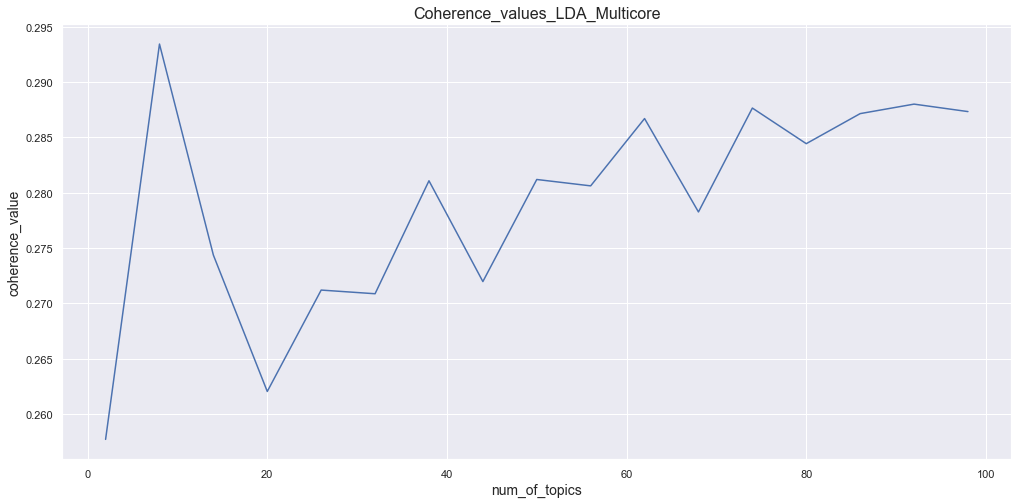

In [16]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(17,8))

sns.lineplot(x=num_of_topics_list, y=coherence_values)
plt.xlabel('num_of_topics',fontsize=14)
plt.ylabel('coherence_value',fontsize=14)
plt.title('Coherence_values_LDA_Multicore',fontsize=16)


In [17]:
%%time

lda_model_multi_coh = gensim.models.LdaMulticore(corpus=corpus_train,id2word=dictionary,
                                           num_topics=num_of_topics_list[key], 
                                           random_state=12345,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

Wall time: 13.4 s


In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_multi_coh, corpus_train, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.058307 -0.008974       1        1  16.553256
2      0.051902 -0.305747       2        1  13.784754
4     -0.362631  0.025122       3        1  12.251680
1     -0.212351  0.294143       4        1  12.017494
0      0.283176 -0.198328       5        1  11.854813
7      0.308663  0.074476       6        1  11.706673
3      0.098538  0.359722       7        1  10.929053
6     -0.225603 -0.240415       8        1  10.902277, topic_info=             Term         Freq        Total Category  logprob  loglift
97        украина  2197.000000  2197.000000  Default  30.0000  30.0000
213         ковид   734.000000   734.000000  Default  29.0000  29.0000
209  девятнадцать   695.000000   695.000000  Default  28.0000  28.0000
96          путин  1481.000000  1481.000000  Default  27.0000  27.0000
129           сша  1884.000000  1884.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
222        случай    93.464893   341.674832   Topic8  -5.2280   0.9199
297          мочь    90.389926   548.040721   Topic8  -5.2615   0.4140
133       заявить    95.855316  1677.340333   Topic8  -5.2028  -0.6459
32          стать    85.035506   394.264913   Topic8  -5.3225   0.6822
110            рф    83.412452   973.626998   Topic8  -5.3418  -0.2410

[473 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5819      7  0.990264  australian
374       1  0.986598         cnn
5820      7  0.990264        open
9499      2  0.977667       welle
5414      1  0.975623         wsj
...     ...       ...         ...
172       5  0.003149      январь
172       6  0.094481      январь
172       7  0.113377      январь
172       8  0.299190      январь
547       3  0.995281      япония

[763 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 5, 2, 1, 8, 4, 7])

In [19]:
#Выполним серилазацию модели
with open("lda_model_multi_coh.pkl", "wb") as f:
    pickle.dump(lda_model_multi_coh, f)

#### LDA 

In [20]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    num_of_topics_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=num_topics,random_state=12345)
        num_of_topics_list.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return num_of_topics_list, coherence_values

In [21]:
%%time
num_of_topics_list, coherence_values  = compute_coherence_values_lda(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [03:56<00:00, 13.90s/it]

Wall time: 3min 56s


In [22]:
print('Максимальное coherence_value: ', max(coherence_values))
key=0
for i in range(0,len(coherence_values)):
    if coherence_values[i]== max(coherence_values):
        key=i
        
print('Оптимальное число тем: ', num_of_topics_list[key])

Максимальное coherence_value:  0.5141673645838338
Оптимальное число тем:  68


Text(0.5, 1.0, 'Coherence_values_LDA')

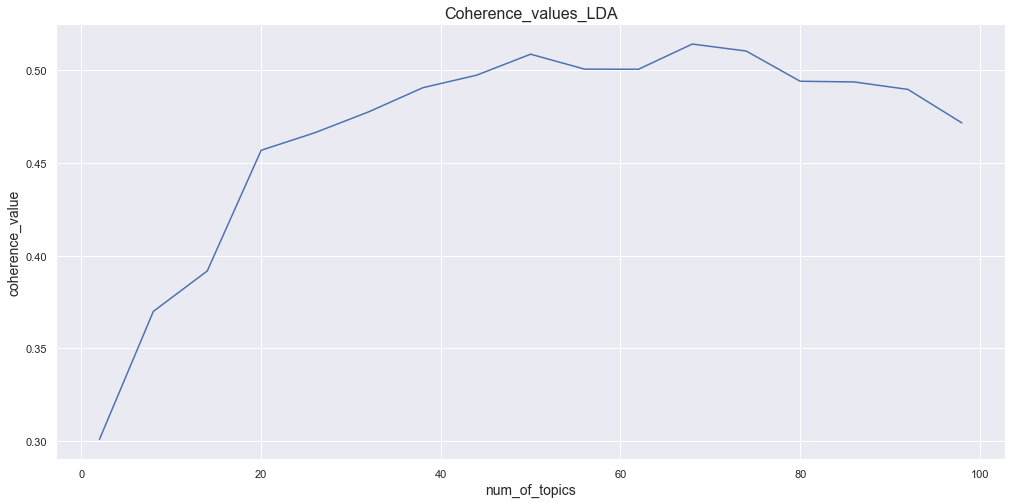

In [23]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(17,8))

sns.lineplot(x=num_of_topics_list, y=coherence_values)
plt.xlabel('num_of_topics',fontsize=14)
plt.ylabel('coherence_value',fontsize=14)
plt.title('Coherence_values_LDA',fontsize=16)


In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_train,
                                           id2word=dictionary,
                                           num_topics=num_of_topics_list[key], 
                                           random_state=12345,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
#lda_model.print_topics()

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_train, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.089848  0.547967       1        1  5.984234
11    -0.214006  0.519646       2        1  5.980870
9      0.479355  0.289582       3        1  5.341014
23     0.234005  0.484198       4        1  4.241228
31    -0.412936  0.358766       5        1  3.784032
...         ...       ...     ...      ...       ...
36    -0.008927 -0.016369      64        1  0.583517
39    -0.008927 -0.016369      65        1  0.583517
42    -0.008927 -0.016369      66        1  0.583517
43    -0.008927 -0.016369      67        1  0.583517
34    -0.008927 -0.016369      68        1  0.583517

[68 rows x 5 columns], topic_info=         Term         Freq        Total Category  logprob  loglift
18     россия  9756.000000  9756.000000  Default  30.0000  30.0000
97    украина  5430.000000  5430.000000  Default  29.0000  29.0000
133   заявить  4717.000000  4717.000000  Default  28.0000  28.0000
96      путин  4355.000000  4355.000000  Default  27.0000  27.0000
129       сша  4469.000000  4469.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
21    министр     0.080561   637.006535  Topic68  -9.3567  -3.8317
24   призвать     0.080561  1321.104256  Topic68  -9.3567  -4.5611
26    санкция     0.080561  1268.328662  Topic68  -9.3567  -4.5203
27        фрг     0.080561   504.901883  Topic68  -9.3567  -3.5992
28      игрок     0.080561    25.128065  Topic68  -9.3567  -0.5989

[3118 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
43       44  0.942518         андрей
13       17  0.997186   безопасность
121       9  0.993454     белоруссия
35       35  0.974074         боевик
293      15  0.984712     британский
...     ...       ...            ...
5        21  0.958147   эвакуировать
268      10  0.974849      экономист
304      34  0.954387  экономический
245       3  0.995596            экс
172       6  0.983484         январь

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 10, 24, 32, 60, 42, 50, 38, 53, 23, 68, 52, 13, 25, 56, 45, 47, 11, 9, 49, 54, 63, 58, 39, 22, 62, 66, 6, 41, 17, 21, 20, 61, 36, 64, 29, 34, 14, 3, 55, 67, 4, 59, 26, 7, 30, 57, 65, 51, 1, 48, 28, 5, 8, 15, 18, 19, 27, 31, 46, 33, 2, 37, 40, 43, 44, 35])

#### Выводы

1.Coherence score для LDA Multicore оказался гораздо меньше чем для LDA. Причину следует установить в дальнейшем. <br>
2.Для работы с inference, в рамках данного проекта, возьмем 5 топиков и LDA Multicore